In [23]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import tqdm
from pydub.silence import split_on_silence
from pydub import AudioSegment
import speech_recognition as sr

import numpy as np
import aubio

def calculate_pitch_variation(audio_file_path):
    # Load audio file
    samplerate, samples = read_audio(audio_file_path)
    samples = samples.astype(np.float32)
    
    # Initialize pitch object
    pitch_o = aubio.pitch("yin", samplerate=samplerate)
    
    # Array to store F0 values
    f0_values = []
    
    # Calculate F0 for each frame
    hop_size = 512
    total_frames = len(samples) // hop_size
    for i in range(total_frames):
        samples_frame = samples[i * hop_size:(i + 1) * hop_size]
        pitch = pitch_o(samples_frame)[0]
        if pitch != 0:
            f0_values.append(pitch)
    
    # Calculate average fundamental frequency
    average_f0 = np.mean(f0_values)
    
    # Calculate standard deviation of fundamental frequency
    std_dev_f0 = np.std(f0_values)
    
    # Calculate coefficient of variation (CV) of fundamental frequency
    cv_f0 = std_dev_f0 / average_f0
    
    return cv_f0

def read_audio(audio_file_path):
    from scipy.io import wavfile
    # Read audio file
    samplerate, samples = wavfile.read(audio_file_path)
    # Convert to mono if stereo
    if len(samples.shape) > 1:
        samples = samples.mean(axis=1)
    return samplerate, samples


def calculate_speaking_rate(audio_file_path):
    # Initialize the recognizer
    recognizer = sr.Recognizer()

    # Load audio file
    with sr.AudioFile(audio_file_path) as source:
        audio_data = recognizer.record(source)

    # Transcribe speech
    try:
        text = recognizer.recognize_google(audio_data)
    except sr.UnknownValueError:
        print("Could not understand audio")
        return
    except sr.RequestError as e:
        print("Error fetching results; {0}".format(e))
        return

    # Count the number of words
    words = text.split()
    word_count = len(words)

    # Get the duration of the audio
    audio_duration = len(audio_data.get_raw_data()) / (audio_data.sample_width * audio_data.sample_rate)

    # Calculate speaking rate (words per minute)
    speaking_rate = (word_count / audio_duration) * 60

    return speaking_rate





def calculate_percent_pause_time(audio_file_path):
    audio = AudioSegment.from_file(audio_file_path)
    silence_threshold = -50  # Adjust as needed
    min_silence_duration = 250  # in milliseconds
    silence_chunks = []

    # Detect silent parts
    silent_chunks = split_on_silence(
        audio,
        min_silence_len=min_silence_duration,
        silence_thresh=silence_threshold
    )

    # Filter silent parts longer than 250 ms
    silent_chunks_filtered = [chunk for chunk in silent_chunks if len(chunk) >= min_silence_duration]

    # Calculate total duration of remaining silent parts
    total_silent_duration = sum(len(chunk) for chunk in silent_chunks_filtered)

    # Calculate total duration of the audio
    total_duration = len(audio)

    # Calculate percent pause time score
    percent_pause_time_score = ((total_duration - total_silent_duration) / total_duration) * 100

    return percent_pause_time_score

# Path to the RAVDESS dataset directory
ravdess_path = "/home/agarwal.aditi/mental_health/RAVDESS-nosil"

# List to store pitch variation features and emotion labels
data = []

# Iterate through the audio files
for root, dirs, files in tqdm.tqdm(os.walk(ravdess_path)):
    for file in files:
        if file.endswith(".wav"):
            # Extract emotion label from file name
            emotion = file.split("-")[2]

            # Extract pitch variation features
            audio_file_path = os.path.join(root, file)
            pitch_variation = calculate_pitch_variation(audio_file_path)
            speaking_rate = calculate_speaking_rate(audio_file_path)
            percent_pause_time = calculate_percent_pause_time(audio_file_path)

            # Append features and emotion label to data list
            data.append((pitch_variation,speaking_rate,percent_pause_time, emotion))

# Convert data list to DataFrame
df = pd.DataFrame(data, columns=["Pitch Variation","Speaking Rate","Percent Pause Time", "Emotion"])



0it [00:00, ?it/s]/tmp/ipykernel_29046/1433254750.py:50: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, samples = wavfile.read(audio_file_path)


Could not understand audio
Could not understand audio
Could not understand audio
Could not understand audio
Could not understand audio


2it [04:05, 122.71s/it]


KeyboardInterrupt: 

In [3]:
import os
import pandas as pd
import numpy as np
import concurrent.futures
import tqdm
from pydub import AudioSegment
import aubio
from pydub.silence import split_on_silence
import speech_recognition as sr
import parselmouth
from parselmouth.praat import call

def calculate_pitch_variation(audio_file_path):
    # Load audio file
    samplerate, samples = read_audio(audio_file_path)
    samples = samples.astype(np.float32)
    
    # Initialize pitch object
    pitch_o = aubio.pitch("yin", samplerate=samplerate)
    
    # Array to store F0 values
    f0_values = []
    
    # Calculate F0 for each frame
    hop_size = 512
    total_frames = len(samples) // hop_size
    for i in range(total_frames):
        samples_frame = samples[i * hop_size:(i + 1) * hop_size]
        pitch = pitch_o(samples_frame)[0]
        if pitch != 0:
            f0_values.append(pitch)
    
    # Calculate average fundamental frequency
    average_f0 = np.mean(f0_values)
    
    # Calculate standard deviation of fundamental frequency
    std_dev_f0 = np.std(f0_values)
    
    # Calculate coefficient of variation (CV) of fundamental frequency
    cv_f0 = std_dev_f0 / average_f0
    
    return cv_f0

def read_audio(audio_file_path):
    from scipy.io import wavfile
    # Read audio file
    samplerate, samples = wavfile.read(audio_file_path)
    # Convert to mono if stereo
    if len(samples.shape) > 1:
        samples = samples.mean(axis=1)
    return samplerate, samples

def calculate_speaking_rate(audio_file_path):
    recognizer = sr.Recognizer()
    with sr.AudioFile(audio_file_path) as source:
        audio_data = recognizer.record(source)
    try:
        text = recognizer.recognize_google(audio_data)
    except sr.UnknownValueError:
        return None
    except sr.RequestError as e:
        return None
    words = text.split()
    word_count = len(words)
    audio_duration = len(audio_data.get_raw_data()) / (audio_data.sample_width * audio_data.sample_rate)
    speaking_rate = (word_count / audio_duration) * 60
    return speaking_rate

def calculate_percent_pause_time(audio_file_path):
    audio = AudioSegment.from_file(audio_file_path)
    silence_threshold = -50
    min_silence_duration = 250
    silent_chunks = split_on_silence(audio, min_silence_len=min_silence_duration, silence_thresh=silence_threshold)
    silent_chunks_filtered = [chunk for chunk in silent_chunks if len(chunk) >= min_silence_duration]
    total_silent_duration = sum(len(chunk) for chunk in silent_chunks_filtered)
    total_duration = len(audio)
    percent_pause_time_score = ((total_duration - total_silent_duration) / total_duration) * 100
    return percent_pause_time_score

def process_audio_file(audio_file_path):
    file_name = os.path.splitext(os.path.basename(audio_file_path))[0]
    actor = file_name.split("-")[6]
    emotion = file_name.split("-")[2]
    pitch_variation = calculate_pitch_variation(audio_file_path)
    speaking_rate = calculate_speaking_rate(audio_file_path)
    percent_pause_time = calculate_percent_pause_time(audio_file_path)
    return (file_name, actor, audio_file_path, pitch_variation, speaking_rate, percent_pause_time, emotion)

# Path to the RAVDESS dataset directory
ravdess_path = "/home/agarwal.aditi/mental_health/RAVDESS-nosil"

# List audio files
audio_files = []
for root, dirs, files in os.walk(ravdess_path):
    for file in files:
        if file.endswith(".wav"):
            audio_files.append(os.path.join(root, file))

# Process audio files in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(tqdm.tqdm(executor.map(process_audio_file, audio_files[:100]), total=len(audio_files[100])))


# Convert results to DataFrame
df = pd.DataFrame(results, columns=["File Name", "Actor", "File Path", "Pitch Variation", "Speaking Rate", "Percent Pause Time", "Emotion"])

# Save DataFrame to CSV
df.to_csv("audio_features.csv", index=False)


/tmp/ipykernel_91866/2748079047.py:47: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, samples = wavfile.read(audio_file_path)
  0%|          | 0/81 [00:02<?, ?it/s]


ConnectionResetError: [Errno 104] Connection reset by peer

In [17]:
import os
import pandas as pd
import numpy as np
from pydub import AudioSegment
import aubio
from pydub.silence import split_on_silence
import speech_recognition as sr
import parselmouth
from parselmouth.praat import call

def calculate_pitch_variation(audio_file_path):
    # Load audio file
    samplerate, samples = read_audio(audio_file_path)
    samples = samples.astype(np.float32)
    
    # Initialize pitch object
    pitch_o = aubio.pitch("yin", samplerate=samplerate)
    
    # Array to store F0 values
    f0_values = []
    
    # Calculate F0 for each frame
    hop_size = 512
    total_frames = len(samples) // hop_size
    for i in range(total_frames):
        samples_frame = samples[i * hop_size:(i + 1) * hop_size]
        pitch = pitch_o(samples_frame)[0]
        if pitch != 0:
            f0_values.append(pitch)
    
    # Calculate average fundamental frequency
    average_f0 = np.mean(f0_values)
    
    # Calculate standard deviation of fundamental frequency
    std_dev_f0 = np.std(f0_values)
    
    # Calculate coefficient of variation (CV) of fundamental frequency
    cv_f0 = std_dev_f0 / average_f0
    
    return cv_f0

def read_audio(audio_file_path):
    from scipy.io import wavfile
    # Read audio file
    samplerate, samples = wavfile.read(audio_file_path)
    # Convert to mono if stereo
    if len(samples.shape) > 1:
        samples = samples.mean(axis=1)
    return samplerate, samples

def calculate_speaking_rate(audio_file_path):
    recognizer = sr.Recognizer()
    with sr.AudioFile(audio_file_path) as source:
        audio_data = recognizer.record(source)
    try:
        # recognizer.reco
        text = recognizer.recognize_whisper(audio_data)
    except sr.UnknownValueError:
        return None
    except sr.RequestError as e:
        return None
    words = text.split()
    word_count = len(words)
    audio_duration = len(audio_data.get_raw_data()) / (audio_data.sample_width * audio_data.sample_rate)
    speaking_rate = (word_count / audio_duration) * 60
    return speaking_rate

def calculate_percent_pause_time(audio_file_path):
    audio = AudioSegment.from_file(audio_file_path)
    silence_threshold = -50
    min_silence_duration = 250
    silent_chunks = split_on_silence(audio, min_silence_len=min_silence_duration, silence_thresh=silence_threshold)
    silent_chunks_filtered = [chunk for chunk in silent_chunks if len(chunk) >= min_silence_duration]
    total_silent_duration = sum(len(chunk) for chunk in silent_chunks_filtered)
    total_duration = len(audio)
    percent_pause_time_score = ((total_duration - total_silent_duration) / total_duration) * 100
    return percent_pause_time_score

def process_audio_file(audio_file_path):
    file_name = os.path.splitext(os.path.basename(audio_file_path))[0]
    actor = file_name.split("-")[6]
    emotion = file_name.split("-")[2]
    pitch_variation = calculate_pitch_variation(audio_file_path)
    speaking_rate = calculate_speaking_rate(audio_file_path)
    percent_pause_time = calculate_percent_pause_time(audio_file_path)
    return (file_name, actor, audio_file_path, pitch_variation, speaking_rate, percent_pause_time, emotion)

# Path to the RAVDESS dataset directory
ravdess_path = "/home/agarwal.aditi/mental_health/RAVDESS-nosil"

# List audio files
audio_files = []
for root, dirs, files in os.walk(ravdess_path):
    for file in files:
        if file.endswith(".wav"):
            audio_files.append(os.path.join(root, file))

# Process audio files
results = []
for audio_file in audio_files[:100]:
    results.append(process_audio_file(audio_file))

# Convert results to DataFrame
df = pd.DataFrame(results, columns=["File Name", "Actor", "File Path", "Pitch Variation", "Speaking Rate", "Percent Pause Time", "Emotion"])

# Save DataFrame to CSV
df.to_csv("audio_features.csv", index=False)


/tmp/ipykernel_91866/2017774900.py:45: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, samples = wavfile.read(audio_file_path)


ModuleNotFoundError: No module named 'whisper'

In [7]:
df

,File Name,Actor,File Path,Pitch Variation,Speaking Rate,Percent Pause Time,Emotion
0,03-01-02-02-02-01-19,19,/home/agarwal.aditi/mental_health/RAVDESS-nosi...,3.727559,NaN,74.375679,2
1,03-01-05-02-01-01-19,19,/home/agarwal.aditi/mental_health/RAVDESS-nosi...,3.466324,NaN,48.451272,5
2,03-01-08-01-01-02-19,19,/home/agarwal.aditi/mental_health/RAVDESS-nosi...,3.642358,NaN,57.930450,8
3,03-01-06-02-01-01-19,19,/home/agarwal.aditi/mental_health/RAVDESS-nosi...,3.656439,NaN,48.475371,6
4,03-01-04-01-01-01-19,19,/home/agarwal.aditi/mental_health/RAVDESS-nosi...,2.964359,NaN,69.595578,4
...,...,...,...,...,...,...,...
95,03-01-07-02-02-02-01,1,/home/agarwal.aditi/mental_health/RAVDESS-nosi...,4.314167,NaN,48.409975,7
96,03-01-06-02-01-01-01,1,/home/agarwal.aditi/mental_health/RAVDESS-nosi...,3.780566,NaN,56.003996,6
97,03-01-04-02-02-01-01,1,/home/agarwal.aditi/mental_health/RAVDESS-nosi...,5.046980,NaN,54.856837,4
98,03-01-05-02-02-02-01,1,/home/agarwal.aditi/mental_health/RAVDESS-nosi...,4.599141,NaN,42.744479,5


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load the audio features DataFrame
df = pd.read_csv("audio_features.csv")

# Extract features and target
X = df.drop(columns=["File Name", "Actor", "File Path", "Emotion"])
y = df["Emotion"]

# X = X.dropna()

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

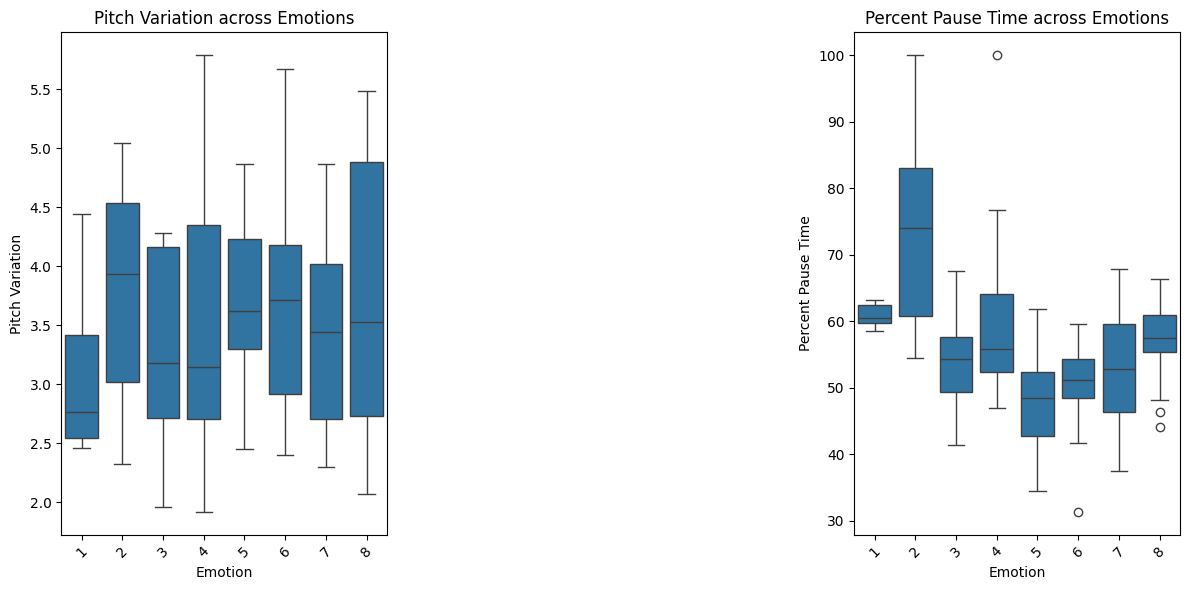

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the audio features DataFrame
df = pd.read_csv("audio_features.csv")

# Plotting
plt.figure(figsize=(12, 6))

# Box plot for Pitch Variation
plt.subplot(1, 3, 1)
sns.boxplot(x='Emotion', y='Pitch Variation', data=df)
plt.title('Pitch Variation across Emotions')
plt.xticks(rotation=45)

# # Box plot for Speaking Rate
# plt.subplot(1, 3, 2)
# sns.boxplot(x='Emotion', y='Speaking Rate', data=df)
# plt.title('Speaking Rate across Emotions')
# plt.xticks(rotation=45)

# Box plot for Percent Pause Time
plt.subplot(1, 3, 3)
sns.boxplot(x='Emotion', y='Percent Pause Time', data=df)
plt.title('Percent Pause Time across Emotions')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [12]:
df

,File Name,Actor,File Path,Pitch Variation,Speaking Rate,Percent Pause Time,Emotion
0,03-01-02-02-02-01-19,19,/home/agarwal.aditi/mental_health/RAVDESS-nosi...,3.727559,NaN,74.375679,2
1,03-01-05-02-01-01-19,19,/home/agarwal.aditi/mental_health/RAVDESS-nosi...,3.466324,NaN,48.451272,5
2,03-01-08-01-01-02-19,19,/home/agarwal.aditi/mental_health/RAVDESS-nosi...,3.642358,NaN,57.930450,8
3,03-01-06-02-01-01-19,19,/home/agarwal.aditi/mental_health/RAVDESS-nosi...,3.656439,NaN,48.475371,6
4,03-01-04-01-01-01-19,19,/home/agarwal.aditi/mental_health/RAVDESS-nosi...,2.964359,NaN,69.595578,4
...,...,...,...,...,...,...,...
95,03-01-07-02-02-02-01,1,/home/agarwal.aditi/mental_health/RAVDESS-nosi...,4.314167,NaN,48.409975,7
96,03-01-06-02-01-01-01,1,/home/agarwal.aditi/mental_health/RAVDESS-nosi...,3.780566,NaN,56.003996,6
97,03-01-04-02-02-01-01,1,/home/agarwal.aditi/mental_health/RAVDESS-nosi...,5.046980,NaN,54.856837,4
98,03-01-05-02-02-02-01,1,/home/agarwal.aditi/mental_health/RAVDESS-nosi...,4.599141,NaN,42.744479,5
